# Rescaling the timing of v<sup>RNAi</sup> and Toll8<sup>RNAi</sup>

Done on 230316 by Polina

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import napari
from matplotlib.lines import Line2D
from helper import get_absolute_timing, get_mean, get_median
import importlib
from scipy.stats import sem
import roifile
import helper

# Set variables and paths of the analysis

In [2]:
# Path to the movies
img_data_path  = "../data/"

# Path to the clicked macrochaete divisions
timing_data_path = "../data/timings_microchaete_divisions_csv/"

timings_paths = [os.path.join(timing_data_path,i) for i in 
                             os.listdir(timing_data_path) if i.endswith(".csv")]
timings_names = [i[:-4].split("/")[-1] for i in timings_paths]

# Path to the clicked delaminations
delamination_manual_count_path = "../data/clicked_delamination_csv/"
new_delaminations_count_path = "../data/new_clicked_delaminations/" 


movies_to_discard = ["210329_vi_pupa1",
                    "210329_Tolloi_pupa1",
                    "210329_Tolloi_pupa2 not ok",
                    "210329_vi_pupa2",
                    "XXXXXX_vi_pupa1",
                    "210604_Tolloi_pupa3",
                    "210604_Tolloi_pupa4",
                    "210830_Tolloi_pupa1",
                    "210830_Tolloi_pupa2",
                    "210604_Tolloi_pupa6"]

movies_etalon = ["210507_vi_pupa1",
                 "210507_vi_pupa3",
                 "210823_vi_pupa1",
                 "220218_vi_pupa3",
                 "220902_vi_pupa1",
                 "210603_Tolloi_pupa1",
                 "210603_Tolloi_pupa3",
                 "210818_Tolloi_pupa2",
                 "210823_Tolloi_pupa2",
                 "210604_Tolloi_pupa6"]

frame_number_etalon = [109, 97, 52, 109, 84, 60, 72, 108, 72, 95]
# This corresponds to 25h58
absolute_timimg = 1558

# Conversion in developmental timings (because temperature is 29°C)
dt = 5 / 0.9
start_time = 1693



# Quantifying the delamination rate for the etalon movies

## Fetching paths and names of the CSVs

In [3]:
#Reading csv files with manually counted delaminations
delamination_names = []
delamination_paths = []

for root, dirs, files in os.walk(delamination_manual_count_path):
    for file in files:
        if file.endswith(".csv"):
            delamination_names.append(file)
            delamination_paths.append(os.path.join(root,file))

delamination_names = np.array(delamination_names)
delamination_paths = np.array(delamination_paths)


## Plotting delamination rate as a function of time

Because the difference in terms of contraction rate for the second event in Tollo<sup>RNAi</sup> - v<sup>RNAi</sup> is occuring starting from 28h13, all movies were cropped at this timepoint

In [4]:
def convert_minutes_to_hour(minutes:int) -> str:

    minutes_str = int(minutes % 60)
    hours_str = int(minutes/60)
    
    fstring = f"{hours_str}h{minutes_str:02d}"
    
    return fstring

### Fetching the values of delamination rate

In [5]:
vi_delamination_rates = []
vi_timings = []
vi_names = []


tolloi_delamination_rates = []
tolloi_timings = []
tolloi_names = []

for i in range(len(delamination_names)):
    
    animal_name = delamination_names[i].replace("_", " ").replace(".csv", "")
    animal_path = delamination_paths[i]
    
    
    temporary_df = pd.read_csv(animal_path)
    ypoints = np.array(temporary_df.loc[:, 'Cumulative sum'])
    
    n_slice = temporary_df.shape[0]

    xpoints = np.arange(start_time, start_time + n_slice * dt, dt )
    xpoints = xpoints[:len(ypoints)]
    
    if "vi" in animal_name: 
        vi_delamination_rates.append(ypoints)
        vi_timings.append(xpoints)
        vi_names.append(animal_name)
        
    if "Tollo" in animal_name:
        tolloi_delamination_rates.append(ypoints)
        tolloi_timings.append(xpoints)
        tolloi_names.append(animal_name)

### Computing the means

vi

In [6]:
minimal_number_of_values = max([len(i) for i in vi_delamination_rates])
cropped_vi_delamination_rate = np.empty((len(vi_delamination_rates), minimal_number_of_values))
cropped_vi_delamination_rate[:] = np.nan
for i in range(len(vi_delamination_rates)):
    cropped_vi_delamination_rate[i,0 :len(vi_delamination_rates[i])] = vi_delamination_rates[i]

mean_vi_delamination_rate = np.nanmean(cropped_vi_delamination_rate, axis=0)
std_vi_delmination_rate = sem(cropped_vi_delamination_rate, axis= 0, nan_policy="omit")
vi_mean_timings = np.arange(start_time, start_time + len(mean_vi_delamination_rate) * dt, dt )[:len(mean_vi_delamination_rate)]

Tolloi

In [7]:
minimal_number_of_values = max([len(i) for i in tolloi_delamination_rates])
cropped_tolloi_delamination_rate = np.empty((len(tolloi_delamination_rates), minimal_number_of_values))
cropped_tolloi_delamination_rate[:] = np.nan
for i in range(len(tolloi_delamination_rates)):
    cropped_tolloi_delamination_rate[i,0 :len(tolloi_delamination_rates[i])] = tolloi_delamination_rates[i]

mean_tolloi_delamination_rate = np.nanmean(cropped_tolloi_delamination_rate, axis=0)
std_tolloi_delmination_rate = sem(cropped_tolloi_delamination_rate, axis= 0, nan_policy="omit")
tolloi_mean_timings = np.arange(start_time, start_time + len(mean_tolloi_delamination_rate) * dt, dt )[:len(mean_tolloi_delamination_rate)]

/tmp/ipykernel_3270940/1612728913.py:7: RuntimeWarning: Mean of empty slice
  mean_tolloi_delamination_rate = np.nanmean(cropped_tolloi_delamination_rate, axis=0)


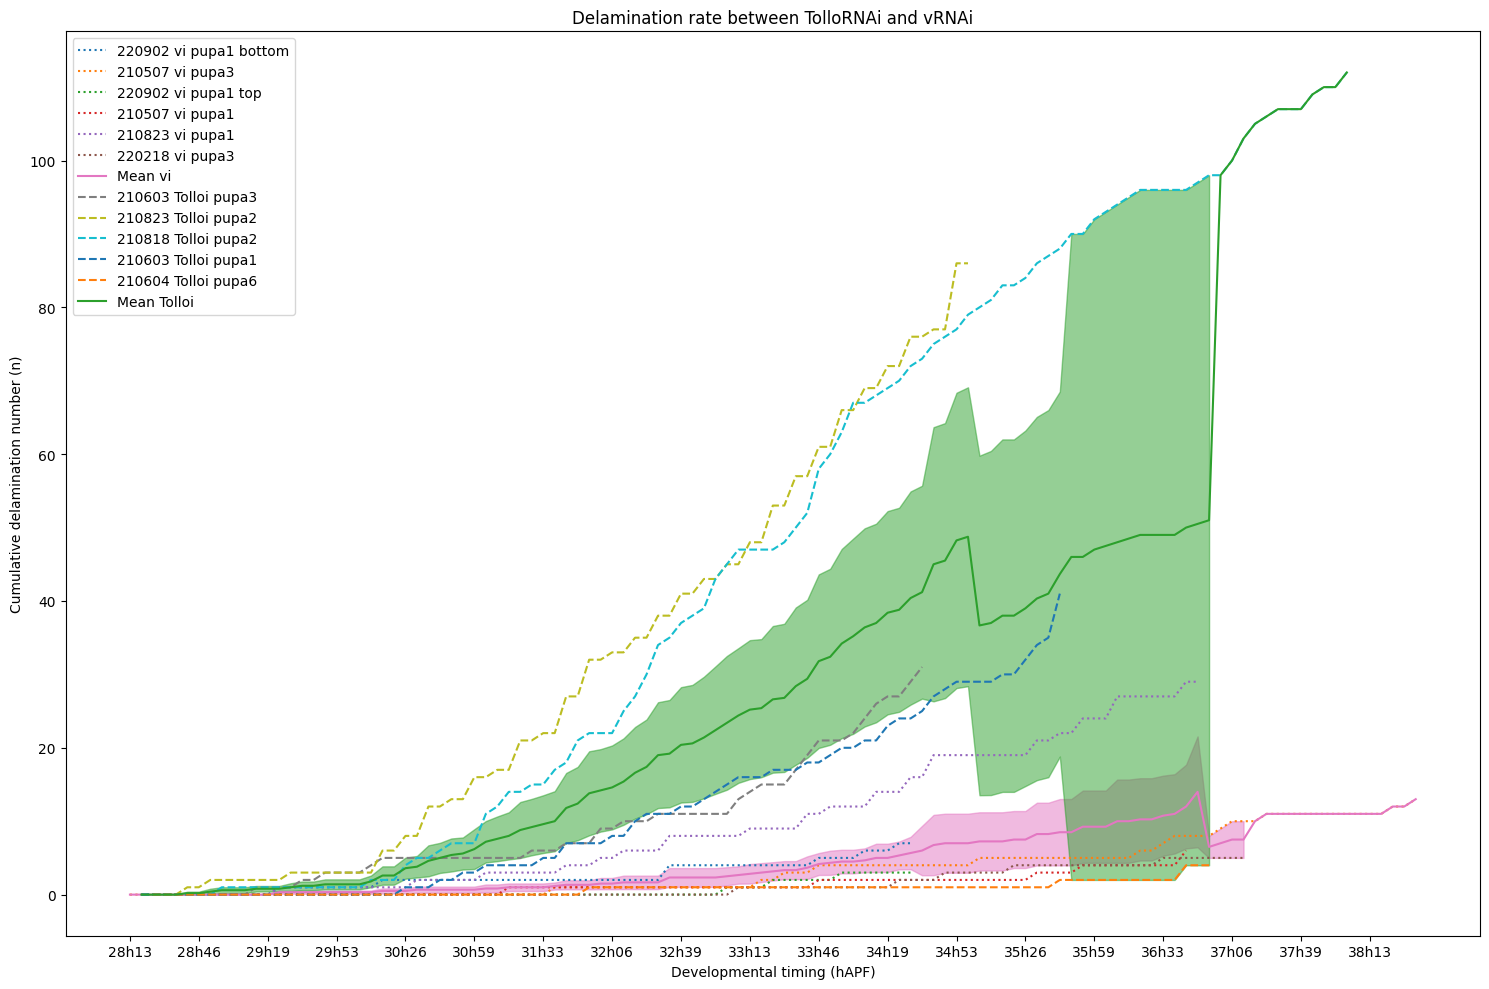

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
start_time = 1693

max_xpoints = []
max_nslice = 0

for i in range(len(vi_names)):
    if len(vi_timings[i]) > len(max_xpoints):
        max_xpoints = vi_timings[i]
    
    ax.plot(vi_timings[i], vi_delamination_rates[i], linestyle = 'dotted', label = vi_names[i])
    
ax.plot(vi_mean_timings, mean_vi_delamination_rate, label = "Mean vi")

ax.fill_between(vi_mean_timings, mean_vi_delamination_rate-std_vi_delmination_rate, mean_vi_delamination_rate+std_vi_delmination_rate,
    alpha=0.5, edgecolor='#e377c2', facecolor='#e377c2')
    
for i in range(len(tolloi_names)):
    if len(tolloi_timings[i]) > len(max_xpoints):
        max_xpoints = tolloi_timings[i]
    
    ax.plot(tolloi_timings[i], tolloi_delamination_rates[i], linestyle = 'dashed', label = tolloi_names[i])
    
ax.plot(tolloi_mean_timings, mean_tolloi_delamination_rate, label = "Mean Tolloi")
ax.fill_between(tolloi_mean_timings, mean_tolloi_delamination_rate-std_tolloi_delmination_rate, mean_tolloi_delamination_rate+std_tolloi_delmination_rate,
    alpha=0.5, edgecolor='#2ca02c', facecolor='#2ca02c')

ax.set_xticks(vi_mean_timings[::6], [convert_minutes_to_hour(i) for i in vi_mean_timings][::6])
ax.set_xlabel("Developmental timing (hAPF)")
ax.set_ylabel("Cumulative delamination number (n)")

ax.set_title("Delamination rate between TolloRNAi and vRNAi")
ax.legend()
fig.tight_layout()
fig.savefig("../results/figures/delamination_rate_between_Tolloi_and_vRNAi_all.png", dpi=300)

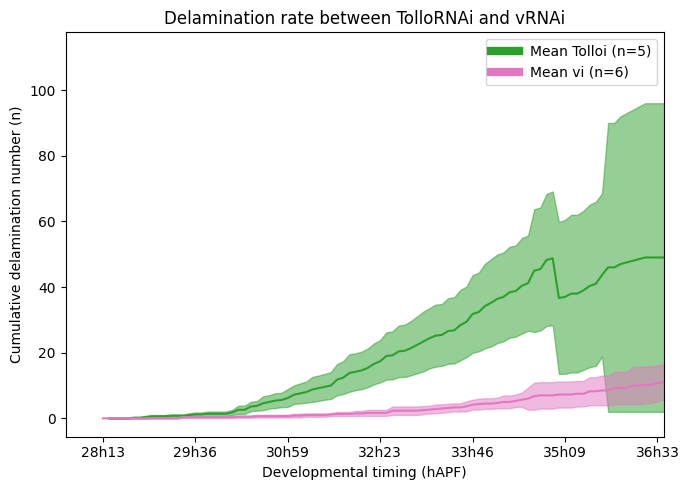

In [9]:
fig, ax = plt.subplots(figsize=(7,5))
start_time = 1693

max_xpoints = []
max_nslice = 0


    
for i in range(len(tolloi_names)):
    if len(tolloi_timings[i]) > len(max_xpoints):
        max_xpoints = tolloi_timings[i]
    
    #ax.plot(tolloi_timings[i], tolloi_delamination_rates[i], linestyle = 'dashed', label = tolloi_names[i])
    
ax.plot(tolloi_mean_timings, mean_tolloi_delamination_rate, label = f"Mean Tolloi (n={cropped_tolloi_delamination_rate.shape[0]})", color='#2ca02c')
ax.fill_between(tolloi_mean_timings, mean_tolloi_delamination_rate-std_tolloi_delmination_rate, mean_tolloi_delamination_rate+std_tolloi_delmination_rate,
    alpha=0.5, edgecolor='#2ca02c', facecolor='#2ca02c')


for i in range(len(vi_names)):
    if len(vi_timings[i]) > len(max_xpoints):
        max_xpoints = vi_timings[i]
    
    #ax.plot(vi_timings[i], vi_delamination_rates[i], linestyle = 'dotted', label = vi_names[i])
    
ax.plot(vi_mean_timings, mean_vi_delamination_rate, label = f"Mean vi (n={cropped_vi_delamination_rate.shape[0]})", color='#e377c2')

ax.fill_between(vi_mean_timings, mean_vi_delamination_rate-std_vi_delmination_rate, mean_vi_delamination_rate+std_vi_delmination_rate,
    alpha=0.5, edgecolor='#e377c2', facecolor='#e377c2')

ax.set_xticks(vi_mean_timings[::15], [convert_minutes_to_hour(i) for i in vi_mean_timings][::15])
ax.set_xlabel("Developmental timing (hAPF)")
ax.set_ylabel("Cumulative delamination number (n)")


ax.set_title("Delamination rate between TolloRNAi and vRNAi")

ax.set_xlim(1659.3888888888882, 2198.833333333346)
leg = ax.legend()


# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

    
fig.tight_layout()
fig.savefig("../results/figures/delamination_rate_between_Tolloi_and_vRNAi.png", dpi=300)

**Discarded movies**

* 210329_vi_pupa1.tif : Black band in the middle of the animal
* 210329_Tolloi_pupa1.tif : too small and no divisions to see
* 210329_Tolloi_pupa2 not ok.tif too small and folds
* 210329_vi_pupa2.tif : fold and too small
* XXXXXX_vi_pupa1.tif : does not include all rows
* 210604_Tolloi_pupa3.tif does not include the region with divisions
* 210604_Tolloi_pupa4.tif does not include the whole region of divisions
* 210830_Tolloi_pupa1.tif the area with divisions is bleached
* 210830_Tolloi_pupa2.tif the area with divisions is bleached
* 210604_Tolloi_pupa6.tif has only 4 rows

It seems that a Tolloi movie has really low delamination rate (210604_Tolloi_pupa6). This lowers the significativity of the results.
To validate that this is indeed a single error and that there are indeed more delamination in Tollo, we will quantify another set of Tollo movies.
This needs a ay to time the movies to add them in the analysi

# Retiming another set of animals using macrochaete divisions

For the timing of the other animals we will use the microchaete divisions timings as it is easier to gather
Let's first plot the macorchaete divisions timings for the eatlon movies (the resultswere gathered using a custom fiji macro)

## Check the Etalon macrochaete divisions timings

Fetch the entire list of movies in the data folder. They must all end with .tif, and it should output a list of all of their paths and names (so two lists in total)

In [10]:
def plot_distribution(movies_etalon, frame_number, absolute_timimg, timings_paths, division_number, row, ax):
    
    # Define the names of all animals
    names = [j.split("/")[-1][:-4] for j in  timings_paths]
    
    # Fetch the list of timings that only corresponds to etalon
    idx_etalon = [names.index(animal) for animal in movies_etalon]
    
    timings = []
    frames_final = []
    names_final = []


    for i, idx in enumerate(idx_etalon):
        
        df_temp = pd.read_csv(timings_paths[idx])

        # Fetch the values and convert into timings
        df_filtered = df_temp[ (df_temp['row'] == row) & (df_temp['division_number'] == division_number)]
        frames = df_filtered["frame"].values
        frames  = absolute_timimg - dt * (frame_number[i] - frames)
        
        
        
        # compute some metrics
        mean = frames.mean()       
        timings.append(mean)

        # store the frames
        frames_final.append(frames)
        
        # store the animal name
        names_final.append(names[idx])
        
    ax.boxplot(frames_final)
    ax.set_xticks(list(range(1,len(movies_etalon)+1)), movies_etalon, rotation="vertical")
    ax.set_title(f"Etalon frames for row {row} and division number {division_number}")
    ax.set_ylabel("Division time (minutes)")

    return ax

In [11]:
a = helper.get_mean(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 3, 3)
b = helper.get_mean(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 4, 3)
c = helper.get_mean(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 3, 5)
d = helper.get_mean(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 4, 5)

In [12]:
#Getting mean of medians per each event
a_median = helper.get_median(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 3, 3)
b_median = helper.get_median(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 4, 3)
c_median = helper.get_median(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 3, 5)
d_median = helper.get_median(movies_etalon, frame_number_etalon, absolute_timimg, timings_paths, 4, 5)

In [13]:
a_median

1277.5

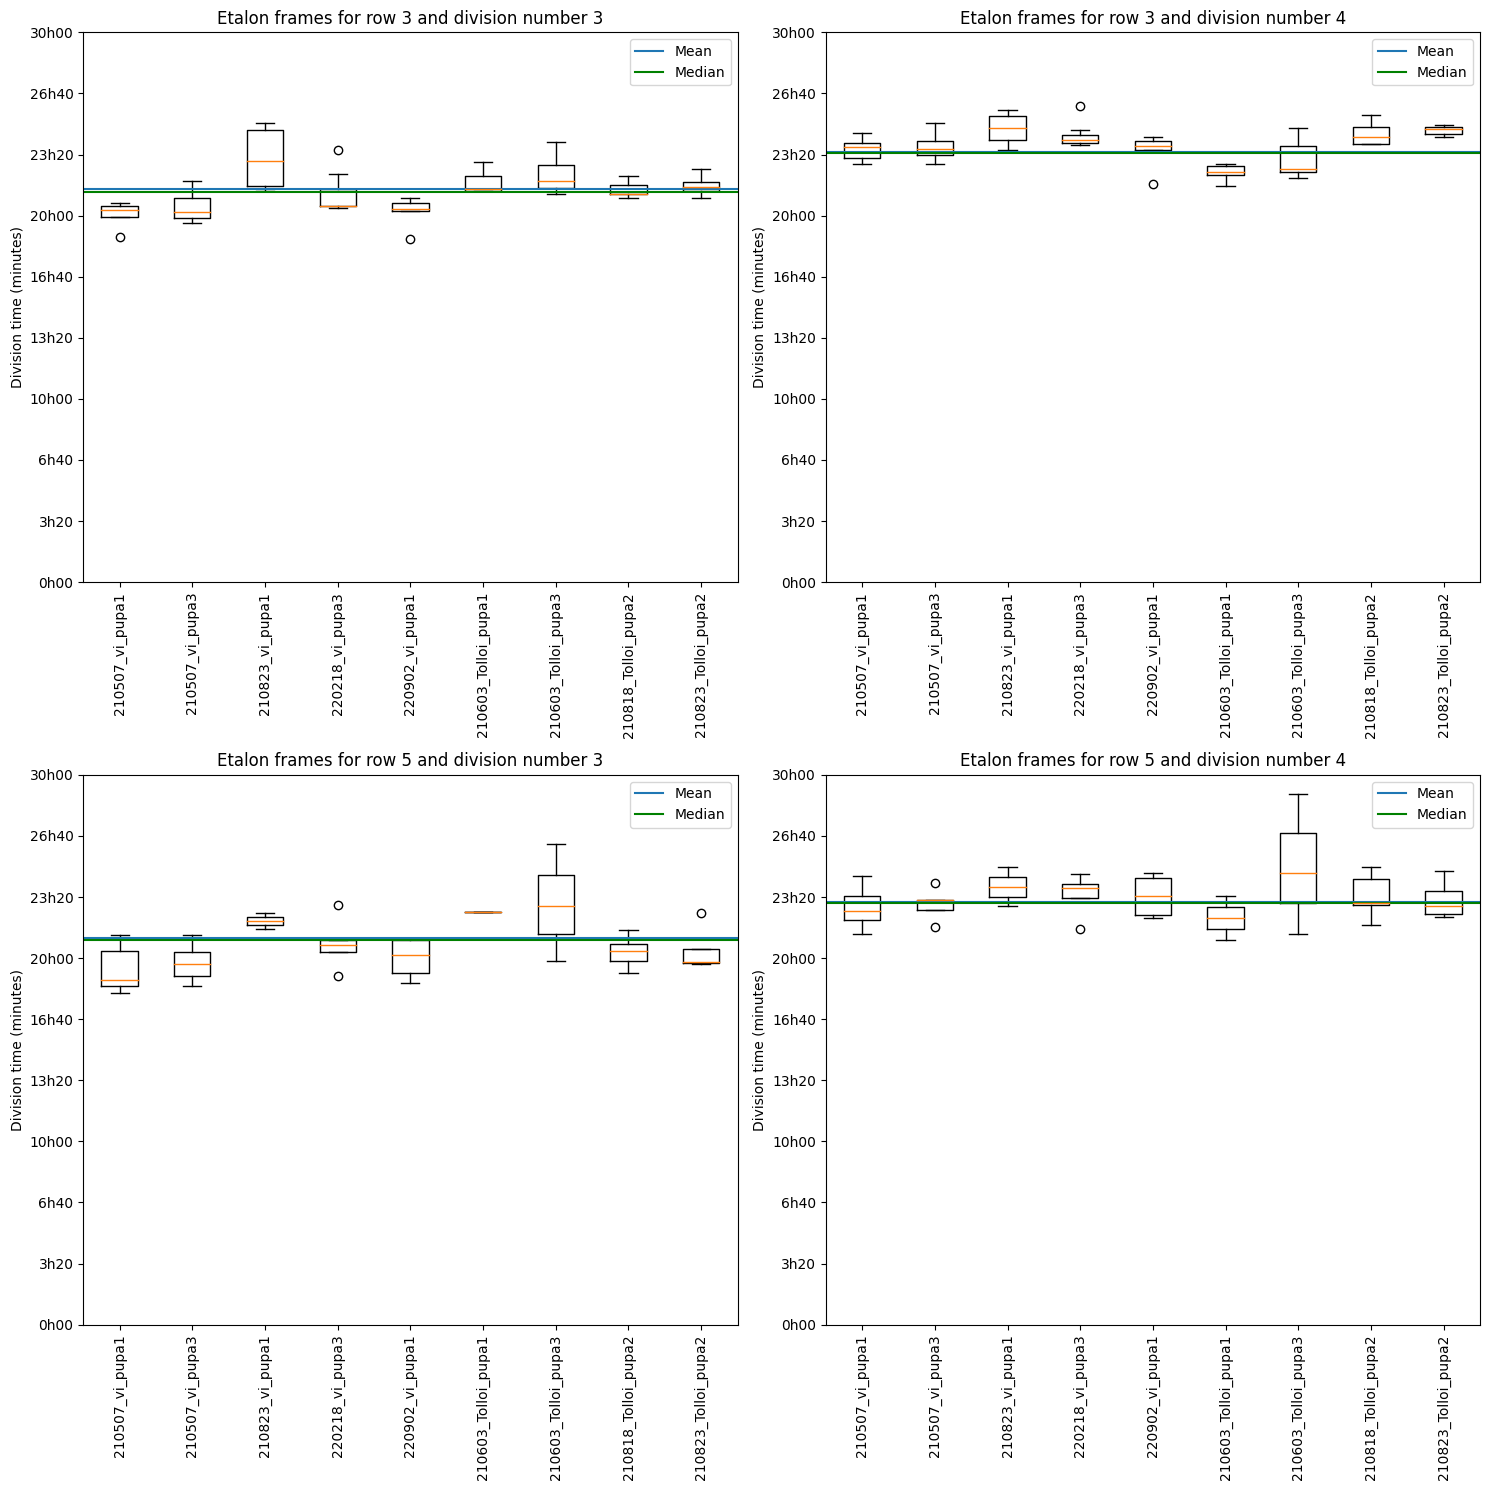

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

# We removed 210604_Tolloi_pupa6 because it cannot be timed with macrochaete divisions
plot_distribution(movies_etalon[:-1], frame_number_etalon, absolute_timimg, timings_paths, 3, 3, ax[0,0])
plot_distribution(movies_etalon[:-1], frame_number_etalon, absolute_timimg, timings_paths, 4, 3, ax[0,1])
plot_distribution(movies_etalon[:-1], frame_number_etalon, absolute_timimg, timings_paths, 3, 5, ax[1,0])
plot_distribution(movies_etalon[:-1], frame_number_etalon, absolute_timimg, timings_paths, 4, 5, ax[1,1])

ax[0,0].set_ylim(0,1800)
ax[0,0].set_yticks(ax[0,0].get_yticks(), [convert_minutes_to_hour(i) for i in ax[0,0].get_yticks()])
ax[0,0].axhline(y = a, label="Mean")
ax[0,0].axhline(y = a_median, color="green", label="Median")
ax[0,0].legend()

ax[0,1].set_ylim(0,1800)
ax[0,1].set_yticks(ax[0,1].get_yticks(), [convert_minutes_to_hour(i) for i in ax[0,1].get_yticks()])
ax[0,1].axhline(y = b, label="Mean")
ax[0,1].axhline(y = b_median, color="green", label="Median")
ax[0,1].legend()

ax[1,0].set_ylim(0,1800)
ax[1,0].set_yticks(ax[1,0].get_yticks(), [convert_minutes_to_hour(i) for i in ax[1,0].get_yticks()])
ax[1,0].axhline(y = c, label="Mean")
ax[1,0].axhline(y = c_median, color="green", label="Median")
ax[1,0].legend()

ax[1,1].set_ylim(0,1800)
ax[1,1].set_yticks(ax[1,1].get_yticks(), [convert_minutes_to_hour(i) for i in ax[1,1].get_yticks()])
ax[1,1].axhline(y = d, label="Mean")
ax[1,1].axhline(y = d_median, color="green", label="Median")
ax[1,1].legend()

fig.tight_layout()

fig.savefig("../results/figures/etalon_macrochaete_divisions_timings.png", dpi=300)

It seems like the row 3 division 4 is the most stable measurement, so we'll take that one

Now we want to get the distribution of timings according to macrochaete divisions once the movies are rescaled using the measurements from the etalons

## Get the frame of interest for all other Tolloi movies

Now that we have all the timings for macrochaete for all etalon movies, we can use this information to retime all the other movies. Thest first question is : how stable are the divisions timings of all other events when we time according to one ?

### If we use Row 3 division n°3 to Retime the other movies 

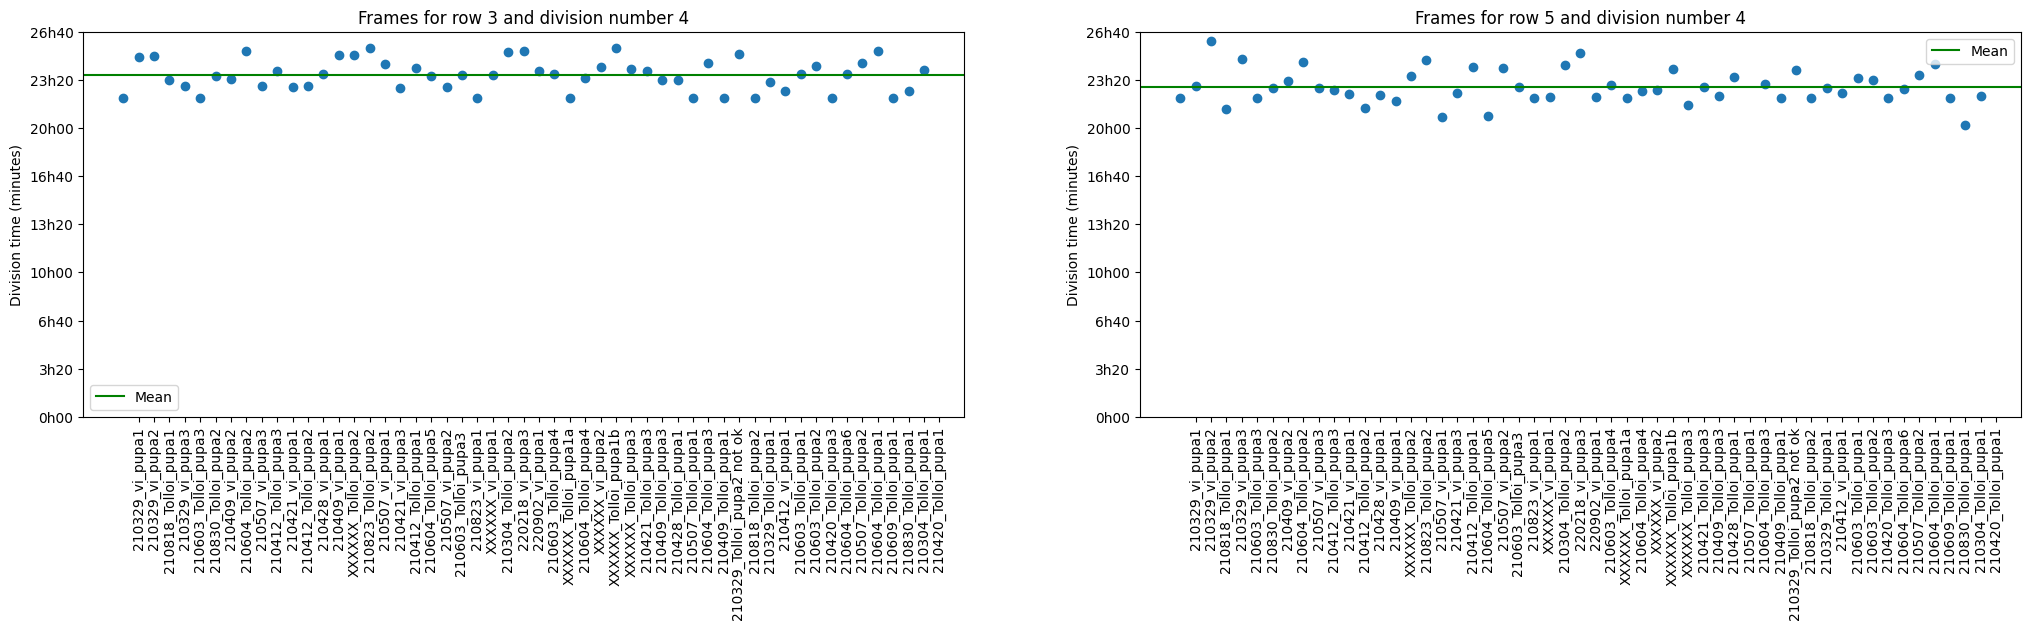

In [15]:
importlib.reload(helper)

#The line is mean of (3,3)
#The dots are mean values of (3,4) frames of all animals

event = (3,3)
#A corresponds to division n°3 row 3
timing = a_median
events_to_evaluate = [(3,4), (5,4)]


axe_x = []
axe_y1 = []
axe_y2 = []

for i in range(len(timings_paths)):
    df_temp = pd.read_csv(timings_paths[i])

    frames_tmp, timings_tmp = helper.get_absolute_timing(df_temp, event, events_to_evaluate, 1324, dt=dt)

    
    #print(timings_tmp)
    axe_x.append(i)
    axe_y1.append(timings_tmp[0])
    axe_y2.append(timings_tmp[1])
    
    
fig, ax = plt.subplots(1,2, figsize=(25,5))
ax[0].scatter(axe_x, axe_y1)

ax[0].set_xticks(list(range(1,len(timings_names)+1)), timings_names, rotation="vertical")
ax[0].set_ylim(0,1600)
ax[0].set_title(f"Frames for row 3 and division number 4")
ax[0].set_ylabel("Division time (minutes)")
ax[0].set_yticks(ax[0].get_yticks(), [convert_minutes_to_hour(i) for i in ax[0].get_yticks()])

ax[1].scatter(axe_x, axe_y2)
ax[1].set_xticks(list(range(1,len(timings_names)+1)), timings_names, rotation="vertical")
ax[1].set_ylim(0,1600)
ax[1].set_title(f"Frames for row 5 and division number 4")
ax[1].set_ylabel("Division time (minutes)")
ax[1].set_yticks(ax[1].get_yticks(), [convert_minutes_to_hour(i) for i in ax[1].get_yticks()])


#Adding the mean values
mean_1 = np.nanmean(np.array(axe_y1))
mean_2 = np.nanmean(np.array(axe_y2))

ax[0].axhline(mean_1, color="green", label="Mean")
ax[1].axhline(mean_2, color="green", label="Mean")

ax[0].legend()
ax[1].legend()

fig.savefig("../results/figures/other_movies_retimes_from_row_3_div_3.png", dpi=300)

### If we use Row 3 division n°4 to Retime the other movies 

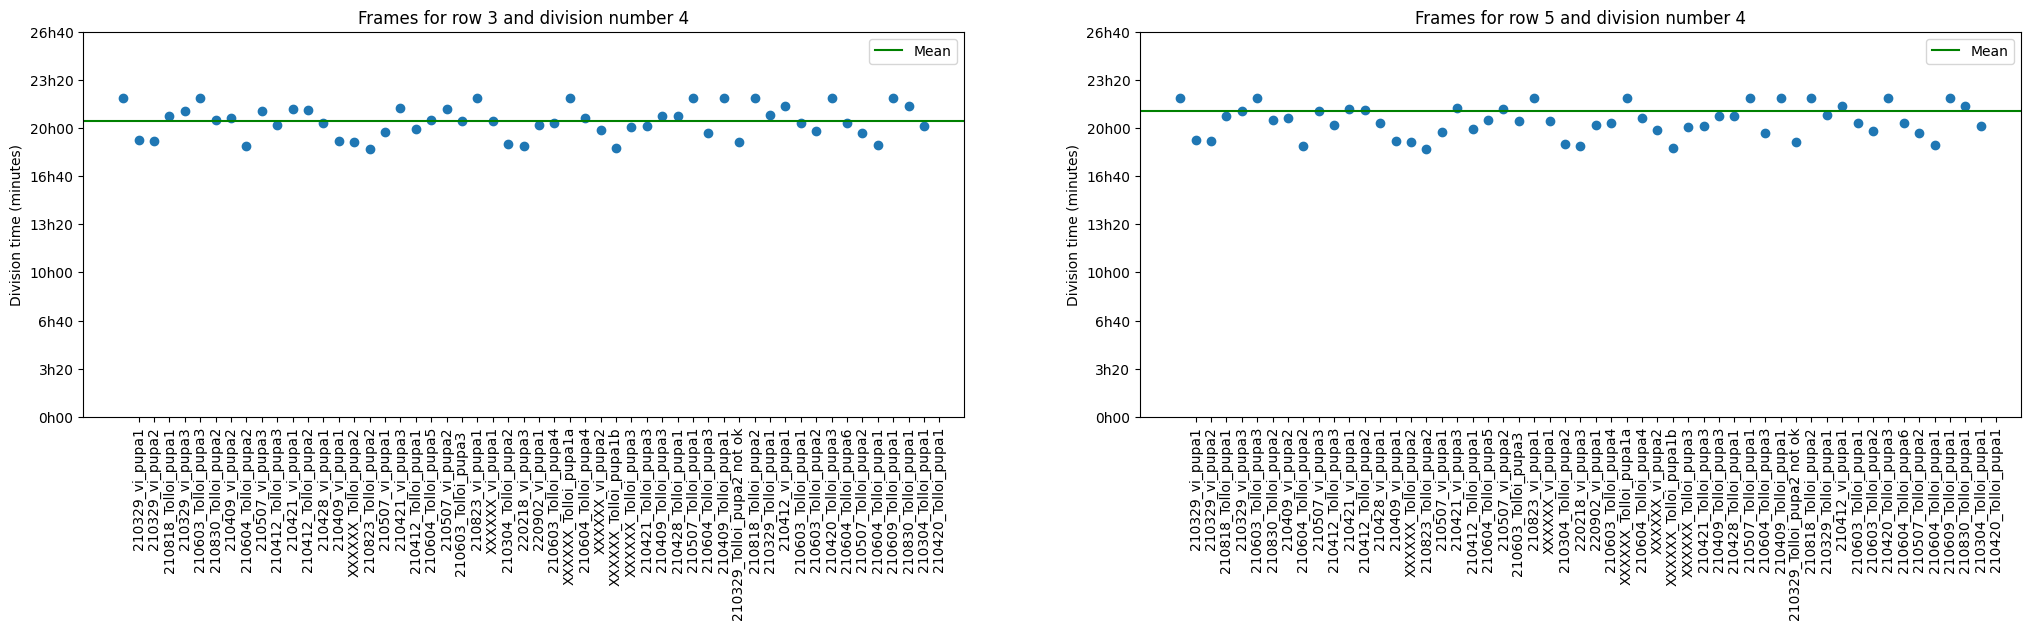

In [16]:
importlib.reload(helper)

#The line is mean of (3,3)
#The dots are mean values of (3,4) frames of all animals

event = (3,4)
#A corresponds to division n°3 row 3
timing = a_median
events_to_evaluate = [(3,3), (5,4)]


axe_x = []
axe_y3 = []
axe_y4 = []

for i in range(len(timings_paths)):
    df_temp = pd.read_csv(timings_paths[i])

    frames_tmp, timings_tmp = helper.get_absolute_timing(df_temp, event, events_to_evaluate, 1324, dt=dt)

    
    #print(timings_tmp)
    axe_x.append(i)
    axe_y3.append(timings_tmp[0])
    axe_y4.append(timings_tmp[1])
    
    
fig, ax = plt.subplots(1,2, figsize=(25,5))
ax[0].scatter(axe_x, axe_y3)

ax[0].set_xticks(list(range(1,len(timings_names)+1)), timings_names, rotation="vertical")
ax[0].set_ylim(0,1600)
ax[0].set_title(f"Frames for row 3 and division number 4")
ax[0].set_ylabel("Division time (minutes)")
ax[0].set_yticks(ax[0].get_yticks(), [convert_minutes_to_hour(i) for i in ax[0].get_yticks()])

ax[1].scatter(axe_x, axe_y3)
ax[1].set_xticks(list(range(1,len(timings_names)+1)), timings_names, rotation="vertical")
ax[1].set_ylim(0,1600)
ax[1].set_title(f"Frames for row 5 and division number 4")
ax[1].set_ylabel("Division time (minutes)")
ax[1].set_yticks(ax[1].get_yticks(), [convert_minutes_to_hour(i) for i in ax[1].get_yticks()])


#Adding the mean values
mean_1 = np.nanmean(np.array(axe_y3))
mean_2 = np.nanmean(np.array(axe_y4))

ax[0].axhline(mean_1, color="green", label="Mean")
ax[1].axhline(mean_2, color="green", label="Mean")

ax[0].legend()
ax[1].legend()

fig.savefig("../results/figures/other_movies_retimes_from_row_3_div_4.png", dpi=300)

### If we use Row 5 Division n°4 to Retime the other movies 

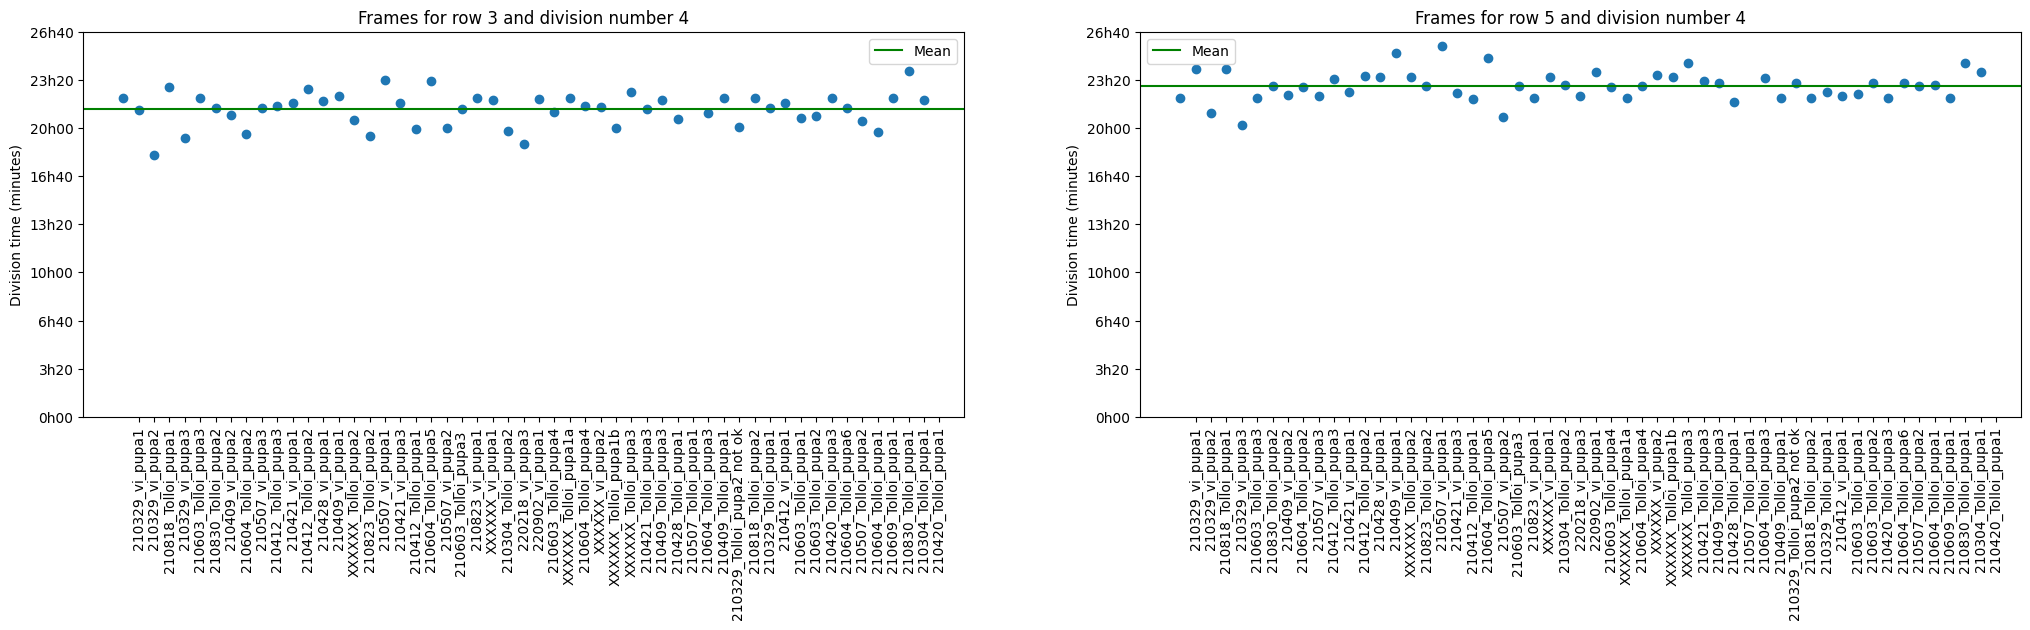

In [17]:
importlib.reload(helper)

#The line is mean of (3,3)
#The dots are mean values of (3,4) frames of all animals

event = (5,4)
#A corresponds to division n°3 row 3
timing = a_median
events_to_evaluate = [(3,3), (3,4)]


axe_x = []
axe_y5 = []
axe_y6 = []

for i in range(len(timings_paths)):
    df_temp = pd.read_csv(timings_paths[i])

    frames_tmp, timings_tmp = helper.get_absolute_timing(df_temp, event, events_to_evaluate, 1324, dt=dt)

    
    #print(timings_tmp)
    axe_x.append(i)
    axe_y5.append(timings_tmp[0])
    axe_y6.append(timings_tmp[1])
    
    
fig, ax = plt.subplots(1,2, figsize=(25,5))
ax[0].scatter(axe_x, axe_y5)

ax[0].set_xticks(list(range(1,len(timings_names)+1)), timings_names, rotation="vertical")
ax[0].set_ylim(0,1600)
ax[0].set_title(f"Frames for row 3 and division number 4")
ax[0].set_ylabel("Division time (minutes)")
ax[0].set_yticks(ax[0].get_yticks(), [convert_minutes_to_hour(i) for i in ax[0].get_yticks()])

ax[1].scatter(axe_x, axe_y6)
ax[1].set_xticks(list(range(1,len(timings_names)+1)), timings_names, rotation="vertical")
ax[1].set_ylim(0,1600)
ax[1].set_title(f"Frames for row 5 and division number 4")
ax[1].set_ylabel("Division time (minutes)")
ax[1].set_yticks(ax[1].get_yticks(), [convert_minutes_to_hour(i) for i in ax[1].get_yticks()])


#Adding the mean values
mean_1 = np.nanmean(np.array(axe_y5))
mean_2 = np.nanmean(np.array(axe_y6))

ax[0].axhline(mean_1, color="green", label="Mean")
ax[1].axhline(mean_2, color="green", label="Mean")

ax[0].legend()
ax[1].legend()

fig.savefig("../results/figures/other_movies_retimes_from_row_5_div_3.png", dpi=300)

### Aggregating all these results into a single boxplot

We want to decide what event is the best to standardize all the other movies

In [18]:

labels = ["r3 div4 by r3 div3",
          "r5 div4 by r3 div3",
          "r3 div3 by r3 div4",
          "r5 div4 by r3 div4",
          "r3 div3 by r5 div4",
          "r3 div4 by r5 div4"]
          

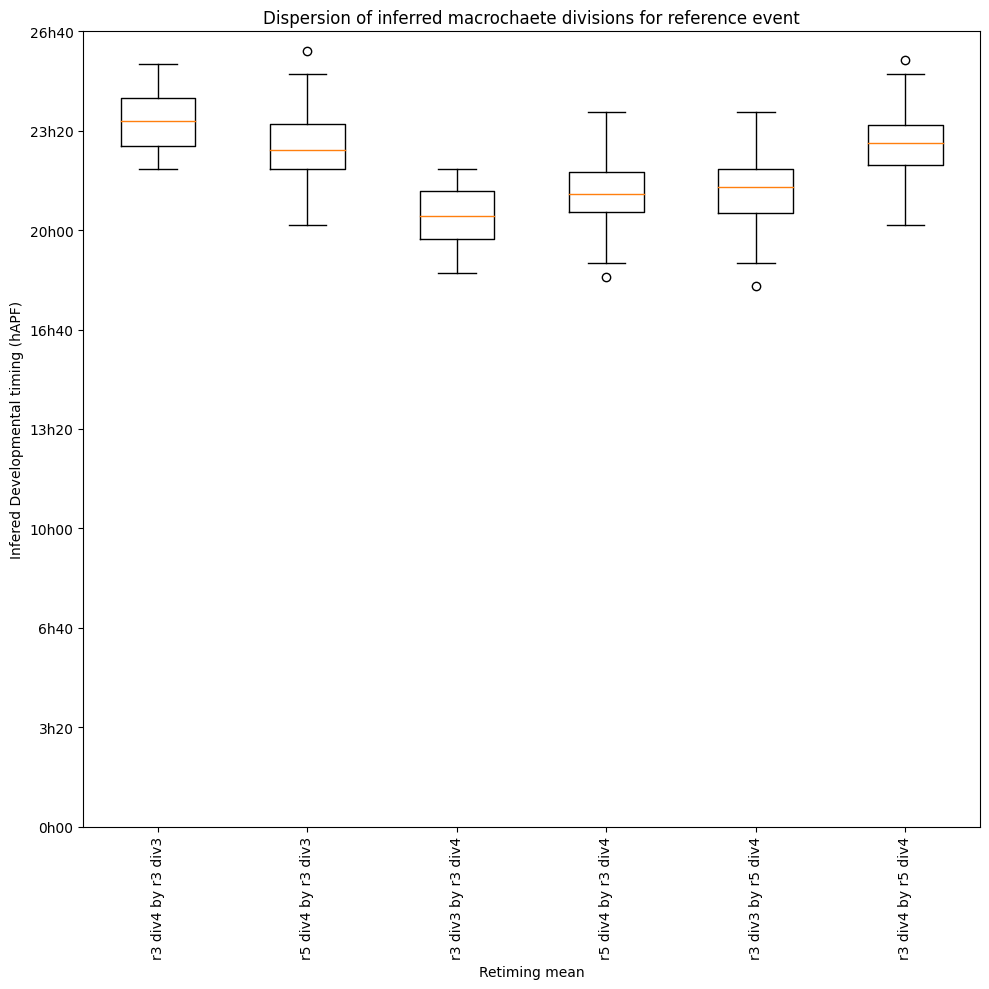

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

data = [axe_y1, axe_y2, axe_y3, axe_y4, axe_y5, axe_y6]

data = [np.array(i) for i in data]
data = [i[~np.isnan(i)] for i in data] 
ax.boxplot(data);
ax.set_ylim(0,1600)
ax.set_xticks(list(range(1,len(data)+1)), labels, rotation="vertical")
ax.set_yticks(ax.get_yticks(), [convert_minutes_to_hour(i) for i in ax.get_yticks()]);
ax.set_ylabel("Infered Developmental timing (hAPF)")
ax.set_xlabel("Retiming mean")

ax.set_title("Dispersion of inferred macrochaete divisions for reference event")
fig.tight_layout()
fig.savefig("../results/figures/other_movies_retimed_boxplot.png", dpi=300) 

Based on this plot, we will use the Row 3, division 3 to retime all animals 

In [20]:
f"Timing of 3rd division of 3rd row is {a_median} for the etalons"

'Timing of 3rd division of 3rd row is 1277.5 for the etalons'

In [21]:
importlib.reload(helper)

<module 'helper' from '/Volumes/u934/equipe_bellaiche/p_pochetnaia/delamination_analysis/notebooks/helper.py'>

We have : 
    
Timing of (3,3) is 1277 minutes

In [22]:
animal_temp = {}

for i in range(len(timings_paths)):
    df_temp = pd.read_csv(timings_paths[i])
    
    animal_temp[timings_names[i]] = helper.get_frame_using_etalon(df_temp, (3,3), timing_reference=a_median, timing_desired=1693, dt=dt)
 


    

### Timings of 25h58 for all animals

In [23]:
animal_temp

{'210329_vi_pupa1': 75.79,
 '210329_vi_pupa2': 75.79,
 '210818_Tolloi_pupa1': 127.12333333333333,
 '210329_vi_pupa3': 130.45666666666668,
 '210603_Tolloi_pupa3': 106.50428571428571,
 '210830_Tolloi_pupa2': 75.79,
 '210409_vi_pupa2': 130.59,
 '210604_Tolloi_pupa2': 139.29000000000002,
 '210507_vi_pupa3': 112.45666666666668,
 '210412_Tolloi_pupa3': 102.79,
 '210421_vi_pupa1': 147.95666666666668,
 '210412_Tolloi_pupa2': 103.49000000000001,
 '210428_vi_pupa1': 140.79000000000002,
 '210409_vi_pupa1': 119.93285714285716,
 'XXXXXX_Tolloi_pupa2': 135.39000000000001,
 '210823_Tolloi_pupa2': 100.12333333333333,
 '210507_vi_pupa1': 120.50428571428571,
 '210421_vi_pupa3': 200.95666666666668,
 '210412_Tolloi_pupa1': 101.64714285714287,
 '210604_Tolloi_pupa5': 108.04,
 '210507_vi_pupa2': 176.79000000000002,
 '210603_Tolloi_pupa3 ': 106.79,
 '210823_vi_pupa1': 96.12333333333333,
 'XXXXXX_vi_pupa1': 75.79,
 '210304_Tolloi_pupa2': 121.165,
 '220218_vi_pupa3': 132.21857142857144,
 '220902_vi_pupa1': 96.

# Counting the delamination for all new rescaled and cropped animals

In [24]:
def get_cumulative_distribution(input_path:"str"):
    
    rois = roifile.roiread(input_path)
    animal_name = "_".join(input_path.split("/")[-1].split("_")[0:3])
    distrib = {}

    for roi in rois:
        if roi.t_position not in distrib.keys():
            distrib[roi.t_position - 1] = 0

        distrib[roi.t_position - 1] += 1

    distrib_sparse  = np.array(list(distrib.items()))
    
    distrib = np.zeros(np.max(distrib_sparse[:,0]) + 1)
    distrib[distrib_sparse[:,0]] = distrib_sparse[:,1]
    
    
    cumul_distrib = np.zeros((distrib.shape[0], 2))
    
    
    cumul_distrib[:,0] = np.arange(0, cumul_distrib.shape[0])
    cumul_distrib[:,1] = np.cumsum(distrib)
    
    return cumul_distrib, animal_name

Ì let you run the last cells :)
below that one

## V<sup>RNAi</sup>

In [25]:
new_vi_names = []
new_vi_delamination_rates = []
new_vi_timings = []

for file in os.listdir(new_delaminations_count_path):
    if "cell_death" in file and file.endswith(".zip") and 'vi' in file:
        full_path = os.path.join(new_delaminations_count_path, file)
        cumul, name = get_cumulative_distribution(full_path)
        new_vi_names.append(name)
        new_vi_delamination_rates.append(cumul[:,1])
        
        n_slice = cumul.shape[0]
        xpoints = np.arange(start_time, start_time + n_slice * dt, dt )
        xpoints = xpoints[:len(cumul[:,1])]
        
        new_vi_timings.append(xpoints)
        

## Tollo<sup>RNAi</sup>

In [26]:
new_Tolloi_names = []
new_Tolloi_delamination_rates = []
new_Tolloi_timings = []

for file in os.listdir(new_delaminations_count_path):
    if "cell_death" in file and file.endswith(".zip") and 'Tolloi' in file:
        full_path = os.path.join(new_delaminations_count_path, file)
        cumul, name = get_cumulative_distribution(full_path)
        new_Tolloi_names.append(name)
        new_Tolloi_delamination_rates.append(cumul[:,1])
        
        n_slice = cumul.shape[0]
        xpoints = np.arange(start_time, start_time + n_slice * dt, dt )
        xpoints = xpoints[:len(cumul[:,1])]
        
        new_Tolloi_timings.append(xpoints)
        

In [27]:
vi_delamination_rates = []
vi_timings = []
vi_names = []


tolloi_delamination_rates = []
tolloi_timings = []
tolloi_names = []

for i in range(len(delamination_names)):
    
    animal_name = delamination_names[i].replace("_", " ").replace(".csv", "")
    animal_path = delamination_paths[i]
    
    
    temporary_df = pd.read_csv(animal_path)
    ypoints = np.array(temporary_df.loc[:, 'Cumulative sum'])
    
    n_slice = temporary_df.shape[0]

    xpoints = np.arange(start_time, start_time + n_slice * dt, dt )
    xpoints = xpoints[:len(ypoints)]
    a
    if "vi" in animal_name: 
        vi_delamination_rates.append(ypoints)
        vi_timings.append(xpoints)
        vi_names.append(animal_name)
        
    if "Tollo" in animal_name:
        tolloi_delamination_rates.append(ypoints)
        tolloi_timings.append(xpoints)
        tolloi_names.append(animal_name)

### Merging the two lists together

In [28]:
vi_delamination_rates = vi_delamination_rates + new_vi_delamination_rates
vi_timings = vi_timings + new_vi_timings
vi_names = vi_names + new_vi_names

tolloi_delamination_rates = tolloi_delamination_rates + new_Tolloi_delamination_rates
tolloi_timings = tolloi_timings + new_Tolloi_timings
tolloi_names = tolloi_names + new_Tolloi_names

### Computing the means

launch the cells, it should be updated, it fetches the data directly onto isis !

In [29]:
minimal_number_of_values = max([len(i) for i in vi_delamination_rates])
cropped_vi_delamination_rate = np.empty((len(vi_delamination_rates), minimal_number_of_values))
cropped_vi_delamination_rate[:] = np.nan
for i in range(len(vi_delamination_rates)):
    cropped_vi_delamination_rate[i,0 :len(vi_delamination_rates[i])] = vi_delamination_rates[i]

mean_vi_delamination_rate = np.nanmean(cropped_vi_delamination_rate, axis=0)
std_vi_delmination_rate = sem(cropped_vi_delamination_rate, axis= 0, nan_policy="omit")
vi_mean_timings = np.arange(start_time, start_time + len(mean_vi_delamination_rate) * dt, dt )[:len(mean_vi_delamination_rate)]

Tolloi

In [30]:
minimal_number_of_values = max([len(i) for i in tolloi_delamination_rates])
cropped_tolloi_delamination_rate = np.empty((len(tolloi_delamination_rates), minimal_number_of_values))
cropped_tolloi_delamination_rate[:] = np.nan
for i in range(len(tolloi_delamination_rates)):
    cropped_tolloi_delamination_rate[i,0 :len(tolloi_delamination_rates[i])] = tolloi_delamination_rates[i]

mean_tolloi_delamination_rate = np.nanmean(cropped_tolloi_delamination_rate, axis=0)
std_tolloi_delmination_rate = sem(cropped_tolloi_delamination_rate, axis= 0, nan_policy="omit")
tolloi_mean_timings = np.arange(start_time, start_time + len(mean_tolloi_delamination_rate) * dt, dt )[:len(mean_tolloi_delamination_rate)]

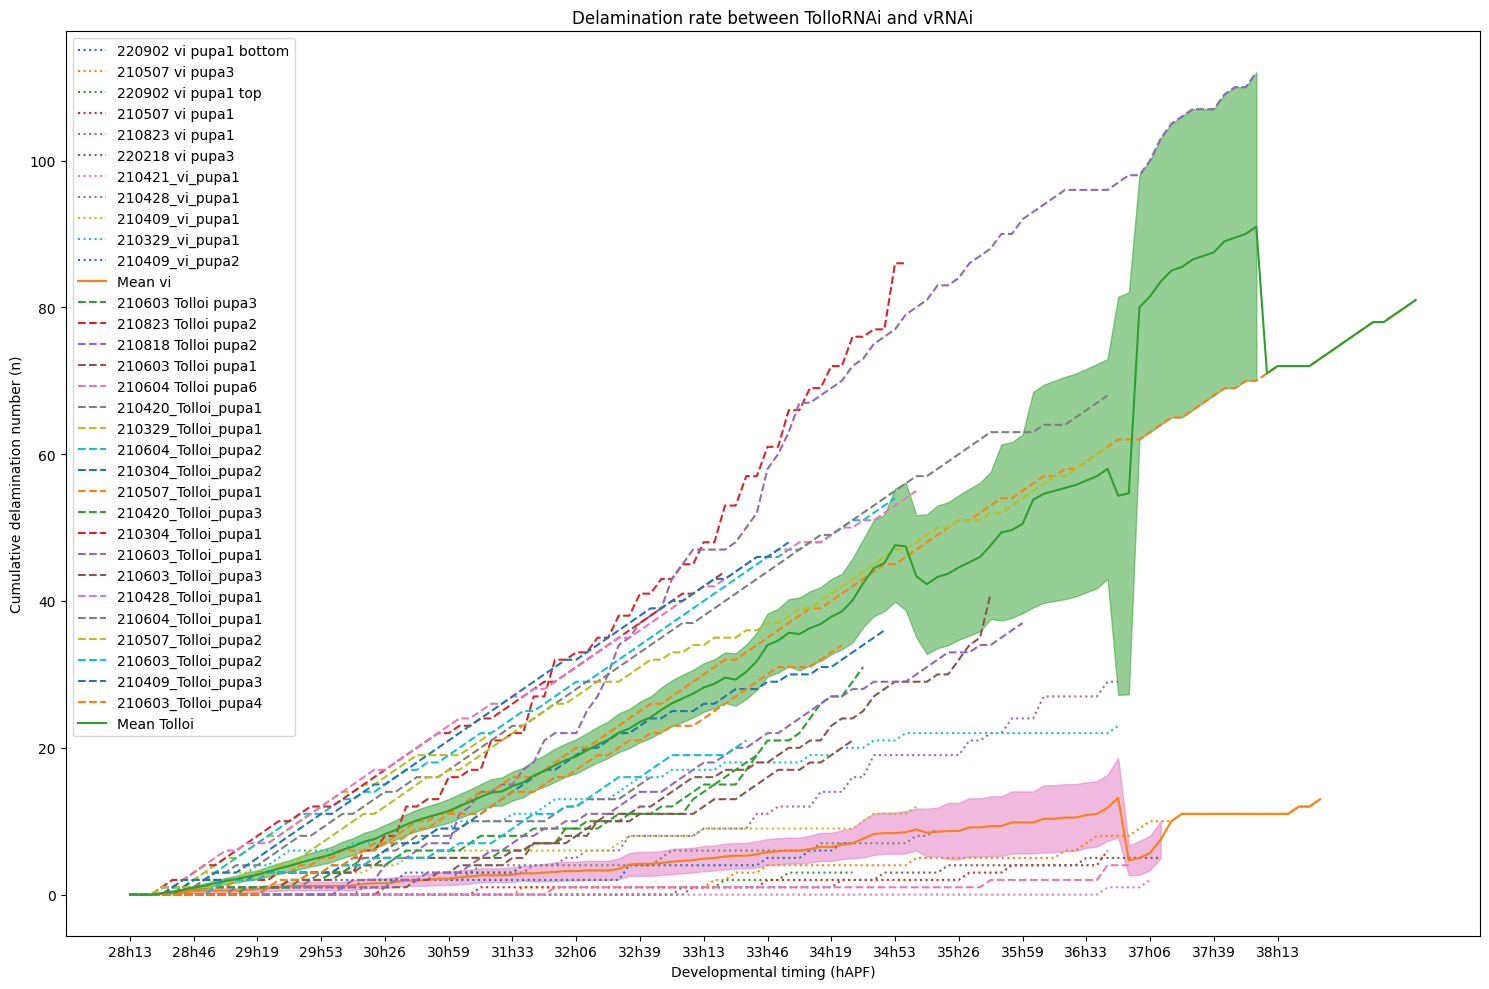

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
start_time = 1693

max_xpoints = []
max_nslice = 0

for i in range(len(vi_names)):
    if len(vi_timings[i]) > len(max_xpoints):
        max_xpoints = vi_timings[i]
    
    ax.plot(vi_timings[i], vi_delamination_rates[i], linestyle = 'dotted', label = vi_names[i])
    
ax.plot(vi_mean_timings, mean_vi_delamination_rate, label = "Mean vi")

ax.fill_between(vi_mean_timings, mean_vi_delamination_rate-std_vi_delmination_rate, mean_vi_delamination_rate+std_vi_delmination_rate,
    alpha=0.5, edgecolor='#e377c2', facecolor='#e377c2')
    
for i in range(len(tolloi_names)):
    if len(tolloi_timings[i]) > len(max_xpoints):
        max_xpoints = tolloi_timings[i]
    
    ax.plot(tolloi_timings[i], tolloi_delamination_rates[i], linestyle = 'dashed', label = tolloi_names[i])
    
ax.plot(tolloi_mean_timings, mean_tolloi_delamination_rate, label = "Mean Tolloi")
ax.fill_between(tolloi_mean_timings, mean_tolloi_delamination_rate-std_tolloi_delmination_rate, mean_tolloi_delamination_rate+std_tolloi_delmination_rate,
    alpha=0.5, edgecolor='#2ca02c', facecolor='#2ca02c')

ax.set_xticks(vi_mean_timings[::6], [convert_minutes_to_hour(i) for i in vi_mean_timings][::6])
ax.set_xlabel("Developmental timing (hAPF)")
ax.set_ylabel("Cumulative delamination number (n)")

ax.set_title("Delamination rate between TolloRNAi and vRNAi")
ax.legend()
fig.tight_layout()
fig.savefig("../results/figures/new_delamination_rate_between_Tolloi_and_vRNAi_all.png", dpi=300)

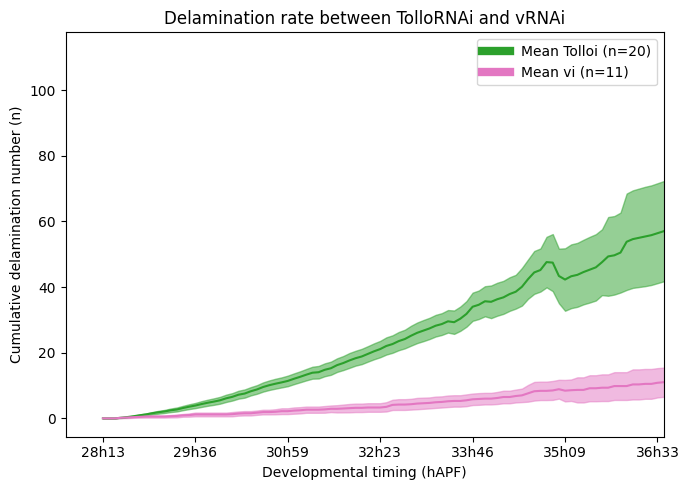

In [32]:
fig, ax = plt.subplots(figsize=(7,5))
start_time = 1693

max_xpoints = []
max_nslice = 0


    
for i in range(len(tolloi_names)):
    if len(tolloi_timings[i]) > len(max_xpoints):
        max_xpoints = tolloi_timings[i]
    
    #ax.plot(tolloi_timings[i], tolloi_delamination_rates[i], linestyle = 'dashed', label = tolloi_names[i])
    
ax.plot(tolloi_mean_timings, mean_tolloi_delamination_rate, label = f"Mean Tolloi (n={cropped_tolloi_delamination_rate.shape[0]})", color='#2ca02c')
ax.fill_between(tolloi_mean_timings, mean_tolloi_delamination_rate-std_tolloi_delmination_rate, mean_tolloi_delamination_rate+std_tolloi_delmination_rate,
    alpha=0.5, edgecolor='#2ca02c', facecolor='#2ca02c')


for i in range(len(vi_names)):
    if len(vi_timings[i]) > len(max_xpoints):
        max_xpoints = vi_timings[i]
    
    #ax.plot(vi_timings[i], vi_delamination_rates[i], linestyle = 'dotted', label = vi_names[i])
    
ax.plot(vi_mean_timings, mean_vi_delamination_rate, label = f"Mean vi (n={cropped_vi_delamination_rate.shape[0]})", color='#e377c2')

ax.fill_between(vi_mean_timings, mean_vi_delamination_rate-std_vi_delmination_rate, mean_vi_delamination_rate+std_vi_delmination_rate,
    alpha=0.5, edgecolor='#e377c2', facecolor='#e377c2')

ax.set_xticks(vi_mean_timings[::15], [convert_minutes_to_hour(i) for i in vi_mean_timings][::15])
ax.set_xlabel("Developmental timing (hAPF)")
ax.set_ylabel("Cumulative delamination number (n)")


ax.set_title("Delamination rate between TolloRNAi and vRNAi")

ax.set_xlim(1659.3888888888882, 2198.833333333346)
leg = ax.legend()


# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

    
fig.tight_layout()
fig.savefig("../results/figures/new_delamination_rate_between_Tolloi_and_vRNAi.png", dpi=300)